<a href="https://colab.research.google.com/github/anjaliasha123/AirlineTweetClassification/blob/main/src/BiLSTMCNNModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Initial required libraries

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Loading the Dataset
*About the data:* <br>
The data is an twitter comments of various US Airlines having sentiments of the tweet: positive, negative or neutral.

*Columns:* <br>


1.   text: The actual tweet
2.   airline: Name of the airline tweeted about
3. latitude, longitude: Location of the tweet
4. airline_sentiment_confidence : Confidence of the sentiment classification of the tweet
5. airline_sentiment: Sentiment of the tweet


In [3]:
#intializing global variables
data = pd.read_csv('https://raw.githubusercontent.com/anjaliasha123/Data_Visualization_projects/master/Streamlit_python/Tweets.csv')
print(data.text.head(2))
print(data.shape)
print(data.airline_sentiment.value_counts())
num_of_categories = 2363
data = data.reindex(np.random.permutation(data.index))
positive = data[data['airline_sentiment'] == 'positive'][:num_of_categories]
negative = data[data['airline_sentiment'] == 'negative'][:num_of_categories]
neutral = data[data['airline_sentiment'] == 'neutral'][:num_of_categories]
data = pd.concat([positive,negative,neutral], ignore_index=True)
data = data.reindex(np.random.permutation(data.index))
print(data.shape)

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
Name: text, dtype: object
(14640, 12)
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64
(7089, 12)


For the purpose of this project, we are considering only the 'text' column of the Xdata

#MOST COMMON VARIABLES:


*   most_common : for the most common words of the dictionary
*   max_len : maximum length of the sequence to be truncated into
* epochs : Number of times the training of the model must be done. It is a value that determines when a model should stop its training explicitly.
* embed_dim : Dimension of a word vector
* batch_size : size of a batch to train during each itteration of model training


In [4]:
most_common = 20000 
max_len = 100 
epochs = 10
embed_dim = 100
batch_size = 100

#Data Preprocessing



*   We need to convert y labels into categorical values
*   We need to convert the 



In [5]:
dataCopy = data

Preprocessing the y labels(dependednt variables). 

In [6]:
data['LABEL'] = 0
data.loc[data.airline_sentiment == 'positive', 'LABEL'] = 0
data.loc[data.airline_sentiment == 'negative', 'LABEL'] = 1
data.loc[data.airline_sentiment == 'neutral', 'LABEL'] = 2
print(data['LABEL'][:10])

3648    1
5774    2
4379    1
5189    2
4891    2
2865    1
5633    2
6133    2
2518    1
2991    1
Name: LABEL, dtype: int64


In [7]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(data['LABEL'], num_classes=3)
print(labels[:10])

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


#Preprocessing the Tweets


*   Removing the name of the airlines @airlinename from the tweets
*   Replacing abbrieviations from the tweets
*   Removing meaningless stopwords
*   Converting texts into lowercase



In [8]:
import re
from tqdm import tqdm
def preProcessTweets(X,colName):
  X[colName] = X[colName].str.replace('@VirginAmerica','')
  X[colName] = X[colName].str.replace('@united','')
  X[colName] = X[colName].str.replace('@SouthwestAir','')
  X[colName] = X[colName].str.replace('@JetBlue','')
  X[colName] = X[colName].str.replace('@AmericanAir','')
  X[colName] = X[colName].str.replace('@USAirways','')
  #stopwords
  # https://gist.github.com/sebleier/554280
  stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
              "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
              'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
              'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
              'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
              'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
              'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
              'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
              'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
              'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
              's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
              've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
              "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
              "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
              'won', "won't", 'wouldn', "wouldn't"]
  #replacing abbreiviations
  def removeAbbrieves(text):
    words = text.split(' ')
    text = ' '.join([w.lower() for w in words])
    text = re.sub(r"won't","will not",text)
    text = re.sub(r"can\'t", "can not",text)
    text = re.sub(r"n\'t", " not", text)
    text= re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have",text)
    text = re.sub(r"\'m", " am", text)
    return text
  #combining all
  preprocessed_text = []
  for sentence in tqdm(X[colName].values):
      sent = removeAbbrieves(sentence)
      sent = sent.replace('\\r', ' ')
      sent = sent.replace('\\n', ' ')
      sent = sent.replace('\\"', ' ')
      sent = sent.replace('http"', ' ')
      sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
      sent = re.sub('[0-9]+', ' ', sent)
      sent = ' '.join(e for e in sent.split(' ') if e.lower() not in stopwords)
      preprocessed_text.append(sent.lower().strip())
  return preprocessed_text

  



In [9]:
X = data['text'].to_frame()
X.head(2)

,text
3648,@united I think problem resolution should be d...
5774,@VirginAmerica I was scheduled for SFO 2 DAL f...


In [10]:
X['text'] = preProcessTweets(X,'text')
X.head(2)

100%|██████████| 7089/7089 [00:00<00:00, 12787.24it/s]


,text
3648,think problem resolution decided end especiall...
5774,scheduled sfo dal flight today changed th...


In [11]:
data['processedText'] = X['text']
data[['text','processedText']].head(2)

,text,processedText
3648,@united I think problem resolution should be d...,think problem resolution decided end especiall...
5774,@VirginAmerica I was scheduled for SFO 2 DAL f...,scheduled sfo dal flight today changed th...


#Word Clouds

In [12]:
positiveTweets = " ".join(data[data.airline_sentiment == 'positive'].processedText.values)
negativeTweets = " ".join(data[data.airline_sentiment == 'negative'].processedText.values)
neutralTweets = " ".join(data[data.airline_sentiment == 'neutral'].processedText.values)

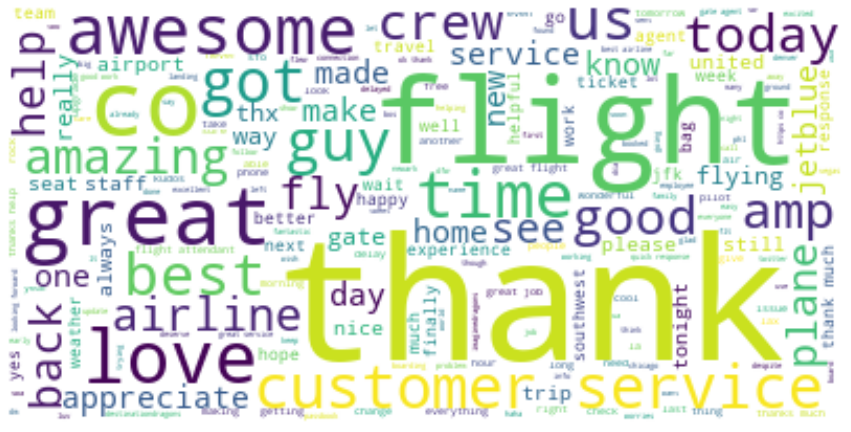

In [13]:
from wordcloud import WordCloud 
wordcloud = WordCloud(background_color="white").generate(positiveTweets)
plt.figure(figsize = (15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

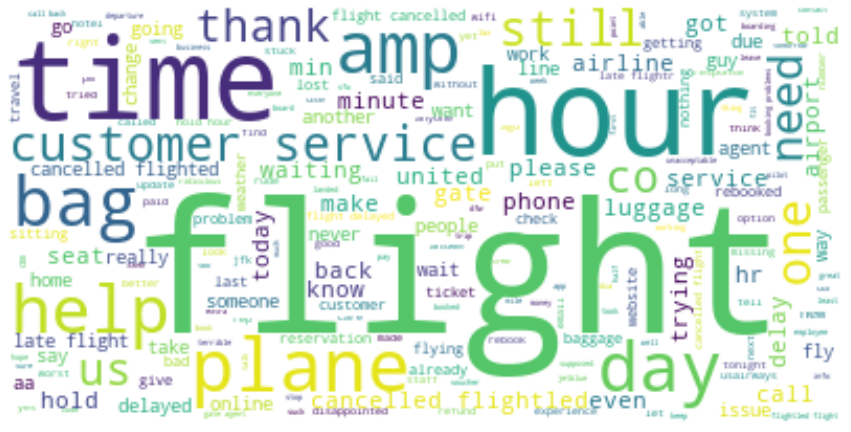

In [14]:
wordcloud = WordCloud(background_color="white").generate(negativeTweets)
plt.figure(figsize = (15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

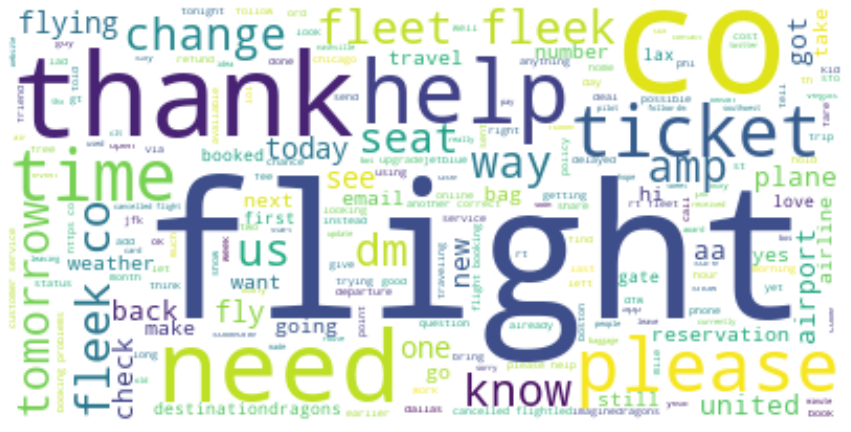

In [15]:
wordcloud = WordCloud(background_color="white").generate(neutralTweets)
plt.figure(figsize = (15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#Approaching towards Deep learning Model


*   dataPreprocessing() : to convert pre-processed tweets into tokens and then created into padded sequences of the word indexes
*   List item



In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def dataPreprocessing(most_common,X,colName):

  tok = Tokenizer(num_words = most_common,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
  tok.fit_on_texts(X[colName].values)
  sequences = tok.texts_to_sequences(X[colName].values)
  word_index = tok.word_index
  print('Found %s unique tokens.' % len(word_index))
  paddedX = pad_sequences(sequences, maxlen = max_len,padding='post')
  return paddedX, len(word_index), word_index,tok

pX, size_unique_wordsX, wordIndex,tok = dataPreprocessing(most_common,data,'processedText')

Found 9160 unique tokens.


#Train-test split
* 80% train data and 20 % test data

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pX , labels, test_size=0.2)

In [18]:
print('Training shape X: {} y:{}'.format(X_train.shape, y_train.shape))
print('Testing shape X: {} y:{}'.format(X_test.shape, y_test.shape))

Training shape X: (5671, 100) y:(5671, 3)
Testing shape X: (1418, 100) y:(1418, 3)


#Creating the WordToVector dictionary

In [19]:
def createEmbeddingMatrix(word_index):
  word2vec = {}
  with open(os.path.join('/content/gdrive/My Drive/glove.6B.100d.txt'),encoding='utf8') as f:
      for line in f:
          values = line.rstrip().rsplit(' ')
          word = values[0]
          coefs = np.asarray(values[1:], dtype='float32')
          word2vec[word] = coefs
  num_of_words = min(most_common, len(word_index)+1)
  embedding_matrix = np.zeros((num_of_words,embed_dim))
  for word,i in word_index.items():
      if i < num_of_words:
          embedd_vec = word2vec.get(word)
          if embedd_vec is not None:
              embedding_matrix[i] = embedd_vec
  return embedding_matrix, num_of_words

embedMatrix, num_of_words = createEmbeddingMatrix(wordIndex)

In [20]:
embedMatrix.shape

(9161, 100)

#Creating the Model

In [21]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import GlobalMaxPooling1D, Dropout
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate
from tensorflow.keras.layers import Conv1D, MaxPooling1D,GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import  Adam

In [22]:
#creating the embedding layer
embedding_layer = Embedding(input_dim=num_of_words,output_dim=max_len,weights=[embedMatrix],input_length=max_len,trainable=False)
#input_layer
input_layer = Input((max_len,),name='InputLayer')
#embedding layer
embedding_layer = embedding_layer(input_layer)
#bi-directional LSTM layer
lstm = Bidirectional(LSTM(50,return_sequences=True))(embedding_layer)
#dropout layer
drop_lstm = Dropout(0.2)(lstm)
#CNN layers
first_conv_layer = Conv1D(filters = 128, kernel_size = 2, activation='relu')(drop_lstm)
second_conv_layer = Conv1D(filters = 128, kernel_size = 3, activation='relu')(drop_lstm)
third_conv_layer = Conv1D(filters = 128, kernel_size = 4, activation='relu')(drop_lstm)
#maxpooling layers
first_max_pooling_layer =  MaxPooling1D((max_len - 2)+1)(first_conv_layer)
second_max_pooling_layer =  MaxPooling1D((max_len - 3)+1)(second_conv_layer)
third_max_pooling_layer =  MaxPooling1D((max_len - 4)+1)(third_conv_layer)
merged = Concatenate(axis=1)([first_max_pooling_layer,second_max_pooling_layer,third_max_pooling_layer])
flatten = Flatten()(merged)
drop_cnn = Dropout(0.2)(flatten)
output_layer = Dense(3, use_bias=False, activation='softmax')(drop_cnn)
model = Model(input_layer,output_layer)
model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy']
             )

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputLayer (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 100)     916100      InputLayer[0][0]                 
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 100)     60400       embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 100, 100)     0           bidirectional[0][0]              
______________________________________________________________________________________________

In [25]:
from tensorflow.keras.callbacks import Callback
import tensorflow

class MyThresholdCallback(tensorflow.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        acc = logs["accuracy"]
        if acc >= self.threshold:
            self.model.stop_training = True


callback=MyThresholdCallback(threshold=0.81)
lstmcnn = model.fit(
           pX, labels,
            batch_size=64,
            epochs=200,
            validation_split=0.2,
            callbacks=[callback]  
            )

Epoch 1/200
89/89 [==============================] - 43s 85ms/step - loss: 1.0389 - accuracy: 0.4773 - val_loss: 0.9554 - val_accuracy: 0.6121
Epoch 2/200
89/89 [==============================] - 5s 58ms/step - loss: 0.8894 - accuracy: 0.6189 - val_loss: 0.8155 - val_accuracy: 0.6488
Epoch 3/200
89/89 [==============================] - 5s 58ms/step - loss: 0.7848 - accuracy: 0.6657 - val_loss: 0.7451 - val_accuracy: 0.6777
Epoch 4/200
89/89 [==============================] - 5s 58ms/step - loss: 0.7395 - accuracy: 0.6822 - val_loss: 0.7167 - val_accuracy: 0.6989
Epoch 5/200
89/89 [==============================] - 5s 58ms/step - loss: 0.7112 - accuracy: 0.6955 - val_loss: 0.6970 - val_accuracy: 0.7123
Epoch 6/200
89/89 [==============================] - 5s 58ms/step - loss: 0.6941 - accuracy: 0.7027 - val_loss: 0.6844 - val_accuracy: 0.7172
Epoch 7/200
89/89 [==============================] - 5s 58ms/step - loss: 0.6761 - accuracy: 0.7127 - val_loss: 0.6704 - val_accuracy: 0.7236
Epoch

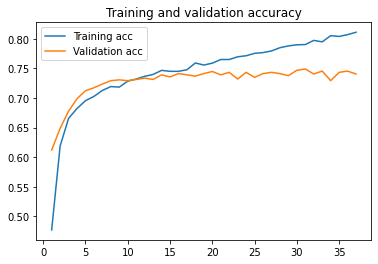

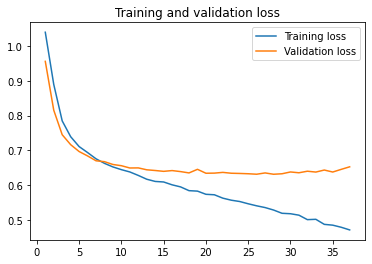

In [26]:
import matplotlib.pyplot as plt

acc = lstmcnn.history['accuracy']
val_acc = lstmcnn.history['val_accuracy']
loss = lstmcnn.history['loss']
val_loss = lstmcnn.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss,label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [27]:
model.save("bilstmCNNTweet.h5")

#Testing the Model

In [ ]:
test_data = pd.read_csv('test.csv')
print(test_data.shape)
test_data.head(2)

In [ ]:
X_test = test_data['text'].to_frame()
actualTweetsDF = test_data[['text']]
y = test_data['airline_sentiment'].to_frame()

We need to pre-process this test data before making predictions using the model

In [ ]:
X_test['text'] = preProcessTweets(X_test,'text')
X_test.head(2)

In [ ]:
tweets = X_test['text'].values
testTweets = [[i] for i in tweets]
print('ORIGINAL TEST TWEETS:')
print(testTweets[:5])
#looping through elements to tokenize and create padded sequence
for i in range(len(testTweets)):
  txt = testTweets[i]
  seq = tok.texts_to_sequences(txt)
  padded = pad_sequences(seq, maxlen=max_len,padding='post')
  testTweets[i] = padded
print('TOKENIZED & SEQUENCED TEST TWEETS:')
print(testTweets[:5])

In [ ]:
#making predictions
labels = ['positive', 'negative','neutral']
conf = []
Label = []
for i in testTweets:
  pred = model.predict(i)
  Label.append(labels[np.argmax(pred)])
  conf.append(pred)
X_test['predicted'] = Label
X_test['actual'] = y.airline_sentiment
X_test['confVal'] = conf
X_test.head(2)


In [ ]:
X_test.head(10)

#Model evaluation

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [30]:

def plot_confusion_matrix(model, X_test, y_test):
    import numpy as np
    import pandas as pd
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    sentiment_classes = ['positive', 'negative', 'neutral']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    return cm

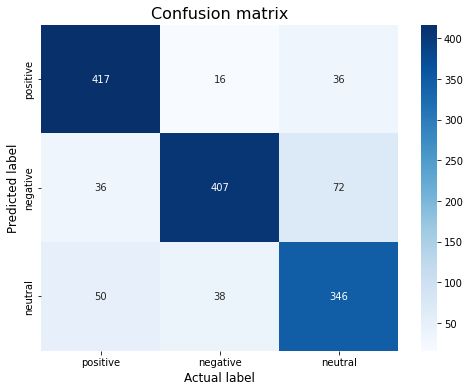

In [31]:
cm = plot_confusion_matrix(model, X_test, y_test)

In [37]:
print('Prediction Accuracy: ')
print('Accuracy of Positive class in % : ')
ap = cm[0][0]/(cm[0][0]+cm[0][1]+cm[0][2])
print((cm[0][0]/(cm[0][0]+cm[0][1]+cm[0][2]))*100)
print('Accuracy of Negative class in %: ')
an = cm[1][1]/(cm[1][1]+cm[1][0]+cm[1][2])
print((cm[1][1]/(cm[1][1]+cm[1][0]+cm[1][2]))*100)
print('Accuracy of Neutral class in %')
anu = cm[2][2]/(cm[2][2]+cm[2][0]+cm[2][1])
print((cm[2][2]/(cm[2][2]+cm[2][0]+cm[2][1]))*100)

Prediction Accuracy: 
Accuracy of Positive class in % : 
88.91257995735607
Accuracy of Negative class in %: 
79.02912621359224
Accuracy of Neutral class in %
79.72350230414746


In [38]:
print('Recall: ')
print('Recall for Positive class :')
rp = (cm[0][0]/(cm[0][0]+cm[1][0]+cm[2][0]))
print((cm[0][0]/(cm[0][0]+cm[1][0]+cm[2][0])))
print('Recall for Negative class :')
rn = (cm[1][1]/(cm[1][1]+cm[0][1]+cm[2][1]))
print((cm[1][1]/(cm[1][1]+cm[0][1]+cm[2][1])))
print('Recall for Neutral class :')
rnu = (cm[2][2]/(cm[2][2]+cm[1][2]+cm[0][2]))
print((cm[2][2]/(cm[2][2]+cm[1][2]+cm[0][2])))

Recall: 
Recall for Positive class :
0.8290258449304175
Recall for Negative class :
0.8828633405639913
Recall for Neutral class :
0.762114537444934


In [40]:
print('F-1 scores:')
print('Positive class:')
print((2*ap*rp)/(ap+rp))
print('Negative class:')
print((2*an*rn)/(an+rn))
print('Neutral class:')
print((2*anu*rnu)/(anu+rnu))

F-1 scores:
Positive class:
0.8580246913580246
Negative class:
0.8340163934426229
Neutral class:
0.7792792792792794
